- 加载包

In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import shap
from sklearn.model_selection import StratifiedKFold
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


- 加载数据

In [3]:
# load data
df_all = pd.read_csv('/Users/wangjingran/Desktop/PTEN mutation/L on ML/data/paras.txt', sep='\t')

# 切分数据
df_ASD_AC = df_all[df_all['Disease'].isin(['ASD', 'ASD_Cancer'])]
df_Cancer_AC = df_all[df_all['Disease'].isin(['Cancer', 'ASD_Cancer'])]

- 基于RFECV的特征消除

In [33]:
X = df_Cancer_AC[['Co.evolution','Conservation','Entropy','RASA','energy',
             'Betweenness','Closeness','Degree','Eigenvector',
             'Clustering.coefficient','Effectiveness','Sensitivity',
             'MSF','DFI','Stiffness']]
y = df_Cancer_AC['Disease']
X1 = X
y1 = y
X1 = X1.reset_index(drop=True)
y1 = y1.reset_index(drop=True)
shuffle_index = np.random.permutation(X1.index)
X1 = X1.iloc[shuffle_index]
y1 = y1.iloc[shuffle_index]
y1_encode = y1.map({'ASD_Cancer': 1, 'Cancer': 0})
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
#for i in tqdm(range(15)):
rfecv = RFECV(
            estimator= LGBMClassifier(verbose = -1),          # 学习器
            #min_features_to_select=i+1, # 最小选择的特征数量
            step=1,                 # 移除特征个数
            cv=StratifiedKFold(5),  # 交叉验证次数
            scoring='accuracy',     # 学习器的评价标准
            verbose = 0
            ).fit(X1, y1_encode)
X_RFECV = rfecv.transform(X)
print("——————————————————————————RFECV特征选择结果————————————————————————")
print("有效特征个数 : %d" % rfecv.n_features_)
print("全部特征等级 : %s" % list(rfecv.ranking_))
feature_importance_scores = rfecv.estimator_.feature_importances_
# 输出每个特征的重要性得分
for feature, importance in zip(range(X.shape[1]), feature_importance_scores):
    print(f"Feature {feature + 1}: {importance}")

selected_feature_names = [name for name, support in zip(X.columns, rfecv.support_) if support]
print(selected_feature_names)

——————————————————————————RFECV特征选择结果————————————————————————
有效特征个数 : 4
全部特征等级 : [3, 11, 9, 7, 5, 1, 1, 1, 1, 10, 2, 8, 6, 12, 4]
Feature 1: 449
Feature 2: 754
Feature 3: 492
Feature 4: 558
['Betweenness', 'Closeness', 'Degree', 'Eigenvector']


- 基于RFE的特征消除

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
X = df_Cancer_AC[['Co.evolution','Conservation','Entropy','RASA','energy',
             'Betweenness','Closeness','Degree','Eigenvector',
             'Clustering.coefficient','Effectiveness','Sensitivity',
             'MSF','DFI','Stiffness']]
y = df_Cancer_AC['Disease']
X1 = X
y1 = y
X1 = X1.reset_index(drop=True)
y1 = y1.reset_index(drop=True)
shuffle_index = np.random.permutation(X1.index)
X1 = X1.iloc[shuffle_index]
y1 = y1.iloc[shuffle_index]
y1_encode = y1.map({'ASD_Cancer': 1, 'Cancer': 0})
# 选择模型和定义RFE对象
select_feature = []
for i in range(15):
    model = GradientBoostingClassifier(n_estimators=1000)
    rfe = RFE(model, n_features_to_select= i+1)
    rfe.fit(X1, y1_encode)
    selected_features = X.columns[rfe.support_]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X1[selected_features], y1_encode, cv=cv)
    print("----------------"+ str(i+1) + "---------------")
    selected_features = X1.columns[rfe.support_]
    print("选择的特征:", selected_features)
    print("交叉验证分数:", scores.mean())
    select_feature.append(selected_features)
    select_feature.append(scores.mean())

In [8]:
select_feature

[Index(['Betweenness'], dtype='object'),
 0.8974376572866621,
 Index(['Betweenness', 'Closeness'], dtype='object'),
 0.9401967513154885,
 Index(['Betweenness', 'Closeness', 'Eigenvector'], dtype='object'),
 0.9466026080988332,
 Index(['Betweenness', 'Closeness', 'Degree', 'Eigenvector'], dtype='object'),
 0.9786547700754976,
 Index(['Betweenness', 'Closeness', 'Degree', 'Eigenvector', 'Effectiveness'], dtype='object'),
 0.976458476321208,
 Index(['energy', 'Betweenness', 'Closeness', 'Degree', 'Eigenvector',
        'Effectiveness'],
       dtype='object'),
 0.9786090139556165,
 Index(['Co.evolution', 'energy', 'Betweenness', 'Closeness', 'Degree',
        'Eigenvector', 'Effectiveness'],
       dtype='object'),
 0.9700754975978038,
 Index(['Co.evolution', 'energy', 'Betweenness', 'Closeness', 'Degree',
        'Eigenvector', 'Effectiveness', 'Stiffness'],
       dtype='object'),
 0.9637153969343399,
 Index(['Co.evolution', 'energy', 'Betweenness', 'Closeness', 'Degree',
        'Eigen

In [4]:
X = df_Cancer_AC[['Co.evolution','Conservation','Entropy','RASA','energy',
             'Betweenness','Closeness','Degree','Eigenvector',
             'Clustering.coefficient','Effectiveness','Sensitivity',
             'MSF','DFI','Stiffness']]
y = df_Cancer_AC['Disease']
y_encode = y.map({'Cancer': 0, 'ASD_Cancer': 1})
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
#for i in tqdm(range(15)):
rfecv = RFECV(
            estimator= GradientBoostingClassifier(n_estimators=2000),          # 学习器
            #min_features_to_select=i+1, # 最小选择的特征数量
            step=1,                 # 移除特征个数
            cv=StratifiedKFold(5),  # 交叉验证次数
            scoring='accuracy',     # 学习器的评价标准
            verbose = 0
            ).fit(X, y_encode)
X_RFECV = rfecv.transform(X)
print("——————————————————————————RFECV特征选择结果————————————————————————")
print("有效特征个数 : %d" % rfecv.n_features_)
print("全部特征等级 : %s" % list(rfecv.ranking_))
selected_feature_names = [name for name, support in zip(X.columns, rfecv.support_) if support]
selected_feature_names

——————————————————————————RFECV特征选择结果————————————————————————
有效特征个数 : 1
全部特征等级 : [3, 15, 12, 9, 5, 2, 7, 1, 4, 6, 13, 10, 14, 8, 11]


['Degree']

In [29]:
X = df_Cancer_AC[['Co.evolution','Conservation','Entropy','RASA','energy',
             'Betweenness','Closeness','Degree','Eigenvector',
             'Clustering.coefficient','Effectiveness','Sensitivity',
             'MSF','DFI','Stiffness']]
y = df_Cancer_AC['Disease']
X1 = X
y1 = y
X1 = X1.reset_index(drop=True)
y1 = y1.reset_index(drop=True)
shuffle_index = np.random.permutation(X1.index)
X1 = X1.iloc[shuffle_index]
y1 = y1.iloc[shuffle_index]
y1_encode = y1.map({'Cancer': 0, 'ASD_Cancer': 1})
gbm_clf = LGBMClassifier()
gbm_clf.fit(X1, y1_encode)
gbm_clf.feature_importances_

[LightGBM] [Info] Number of positive: 41, number of negative: 427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 468, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087607 -> initscore=-2.343212
[LightGBM] [Info] Start training from score -2.343212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

array([100,  20,  67,  93, 138, 213, 548, 353, 197,  55, 161,  64,  81,
         0, 172], dtype=int32)

- 数据切分——对于ASD和ASD_Cancer

In [11]:
# 选择数据    特征选取交集
X_1 = df_Cancer_AC[['Co.evolution', 'Closeness', 'Degree', 'Stiffness']]
X_2 = df_Cancer_AC[['energy', 'Betweenness', 'Degree']]
y = df_Cancer_AC['Disease']
# 交叉验证 
X1 = X_1
X2 = X_2
y1 = y
X1 = X1.reset_index(drop=True)
X2 = X2.reset_index(drop=True)
y1 = y1.reset_index(drop=True)
shuffle_index = np.random.permutation(X1.index)
X1 = X1.iloc[shuffle_index]
X2 = X2.iloc[shuffle_index]
y1 = y1.iloc[shuffle_index]
y1_encode = y1.map({'Cancer': 0, 'ASD_Cancer': 1})
Site = df_Cancer_AC.reset_index(drop=True)[['Site']].iloc[shuffle_index]

- 使用多种方法计算IntegratedScore
- 查询资料得分制应该是预测为1的概率值

In [ ]:
# 调参
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
model = XGBClassifier()
# 定义要调优的参数网格
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001,0.0001,0.00001],
    'n_estimators': list(range(100, 1100, 100)),
    'max_depth': list(range(3,10))
}

# 使用GridSearchCV进行参数搜索和交叉验证
grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(5), n_jobs=-1)
grid_search.fit(X1, y1_encode)

In [14]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400}
Best cross-validation score: 0.97


In [ ]:
from sklearn.model_selection import GridSearchCV
# 定义参数网格
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [4, 6, 8],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5],  # l2_leaf_reg的候选值
    'bagging_temperature': [0.6, 0.8, 1.0]  # bagging_temperature的候选值
}

# 创建CatBoost分类器
model = CatBoostClassifier()

# 使用GridSearchCV进行参数搜索和交叉验证
grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(5), n_jobs=-1)
grid_search.fit(X1, y1_encode)

In [16]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'bagging_temperature': 0.6, 'depth': 6, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.5}
Best cross-validation score: 0.99


In [ ]:
import logging
# 设置LightGBM的日志级别为ERROR
#logging.getLogger('lightgbm').setLevel(logging.ERROR)

from sklearn.model_selection import GridSearchCV
model = LGBMClassifier()
# 定义要调优的参数网格
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': list(range(1000, 6000, 1000)),
    'max_depth': list(range(3,10))
}

# 使用GridSearchCV进行参数搜索和交叉验证
grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(5), n_jobs=-1)
grid_search.fit(X1, y1_encode)

In [19]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 2000}
Best cross-validation score: 0.99


In [11]:
n_iterations = 1
k = 5
stratified_kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

In [13]:
# xgboost的stacking和voting
import warnings
warnings.filterwarnings('ignore')
X_1 = df_Cancer_AC[['ddG','Betweenness', 'Closeness', 'Degree', 'Eigenvector', 'Effectiveness']]
y = df_Cancer_AC['Disease']
# 交叉验证 
X1 = X_1
y1 = y
X1 = X1.reset_index(drop=True)
y1 = y1.reset_index(drop=True)
shuffle_index = np.random.permutation(X1.index)
X1 = X1.iloc[shuffle_index]
y1 = y1.iloc[shuffle_index]
Site = df_Cancer_AC.reset_index(drop=True)[['Site']].iloc[shuffle_index]
y1_encode = y1.map({'Cancer': 0, 'ASD_Cancer': 1})
scores_st = []
scores_vt = []
base_model = [
            #('rf', RandomForestClassifier(n_estimators=1000, n_jobs=-1)), 
            #('ada', AdaBoostClassifier(n_estimators=1200,learning_rate=0.1)),
            #('gb', GradientBoostingClassifier(n_estimators=1000)),
            ('gbm', LGBMClassifier(learning_rate=0.01, n_estimators = 1000,max_depth=4)),
            ('xgboost',XGBClassifier(learning_rate=0.1, n_estimators = 1700,max_depth = 3)),
            #('cat',CatBoostClassifier(iterations = 700, bagging_temperature=0.6, l2_leaf_reg=3,learning_rate=0.1))
            ]
meta_model = LogisticRegression(max_iter=10000000)
stacking_clf = StackingClassifier(estimators=base_model, final_estimator=meta_model, stack_method='predict_proba')
voting_clf = VotingClassifier(estimators=base_model, voting='soft')
for _ in tqdm(range(n_iterations)):
    score_st = cross_val_predict(stacking_clf, X1, y1, cv=stratified_kfold, method="predict_proba")
    scores_st.append(score_st[:,0])
'''for _ in tqdm(range(n_iterations)):
    score_vt = cross_val_predict(voting_clf, X1, y1, cv=stratified_kfold, method="predict_proba")
    scores_vt.append(score_vt[:,1])'''

scores_st = np.array(scores_st)
scores_st = np.mean(scores_st, axis=0)
'''scores_vt = np.array(scores_vt)
scores_vt = np.mean(scores_vt, axis=0)'''
ASD_AC_st = y1.to_frame()
ASD_AC_vt = y1.to_frame()
# 添加新列
ASD_AC_st['Site'] = Site 
ASD_AC_st['IntegratedScore'] = scores_st
#ASD_AC_st['IntegratedScore_1'] = scores_st_1
#ASD_AC_st['IntegratedScore_2'] = scores_st_2

#ASD_AC_vt['Site'] = Site 
#ASD_AC_vt['IntegratedScore'] = scores_vt

# 保存回paras.txt文件
ASD_AC_st.to_csv('/Users/wangjingran/Desktop/PTEN mutation/Research-main/data/Score_new_new/Cancer_AC_Stacking_new2.txt', sep='\t', index=False, header=True)

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 341, number of negative: 33
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 451
[LightGBM] [Info] Number of data points in the train set: 374, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911765 -> initscore=2.335375
[LightGBM] [Info] Start training from score 2.335375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

100%|██████████| 1/1 [00:13<00:00, 13.80s/it]


In [7]:
# xgboost的stacking和voting
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso
X_1 = df_Cancer_AC[['Betweenness', 'Closeness', 'Degree', 'Eigenvector', 'Effectiveness']]
y = df_Cancer_AC['Disease']
# 交叉验证 
X1 = X_1
y1 = y
X1 = X1.reset_index(drop=True)
y1 = y1.reset_index(drop=True)
shuffle_index = np.random.permutation(X1.index)
X1 = X1.iloc[shuffle_index]
y1 = y1.iloc[shuffle_index]
Site = df_Cancer_AC.reset_index(drop=True)[['Site']].iloc[shuffle_index]
y1_encode = y1.map({'Cancer': 0, 'ASD_Cancer': 1})
scores_st = []
scores_vt = []
base_model = [
            #('rf', RandomForestClassifier(n_estimators=1000, n_jobs=-1)), 
            #('ada', AdaBoostClassifier(n_estimators=1200,learning_rate=0.1)),
            #('gb', GradientBoostingClassifier(n_estimators=1000)),
            ('gbm', LGBMRegressor(learning_rate=0.01, n_estimators = 1000,max_depth=4)),
            ('xgboost',XGBRegressor(learning_rate=0.1, n_estimators = 1700,max_depth = 3)),
            ('cat',CatBoostRegressor(iterations = 700, bagging_temperature=0.6, l2_leaf_reg=3,learning_rate=0.1))
            ]
meta_model = Lasso(alpha=0.0001)
stacking_clf = StackingRegressor(estimators=base_model, final_estimator=meta_model)
#voting_clf = VotingClassifier(estimators=base_model, voting='soft')
for _ in tqdm(range(n_iterations)):
    #score_st = cross_val_predict(stacking_clf, X1, y1, cv=stratified_kfold, method="predict_proba")
    score_st = cross_val_predict(stacking_clf, X1, y1_encode, cv=stratified_kfold)
    #scores_st.append(score_st[:,1])
    scores_st.append(score_st)
'''for _ in tqdm(range(n_iterations)):
    score_vt = cross_val_predict(voting_clf, X1, y1, cv=stratified_kfold, method="predict_proba")
    scores_vt.append(score_vt[:,1])'''

scores_st = np.array(scores_st)
#scores_st = np.mean(scores_st, axis=0)
'''scores_vt = np.array(scores_vt)
scores_vt = np.mean(scores_vt, axis=0)'''
ASD_AC_st = y1.to_frame()
ASD_AC_vt = y1.to_frame()
# 添加新列
ASD_AC_st['Site'] = Site 
ASD_AC_st['IntegratedScore'] = score_st
#ASD_AC_st['IntegratedScore_1'] = scores_st_1
#ASD_AC_st['IntegratedScore_2'] = scores_st_2

#ASD_AC_vt['Site'] = Site 
#ASD_AC_vt['IntegratedScore'] = scores_vt

# 保存回paras.txt文件
ASD_AC_st.to_csv('/Users/wangjingran/Desktop/PTEN mutation/Research-main/data/Score_new_new/Cancer_AC_Stacking_regre1.txt', sep='\t', index=False, header=True)

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 374, number of used features: 5
[LightGBM] [Info] Start training from score 0.088235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████| 1/1 [00:18<00:00, 18.60s/it]

670:	learn: 0.0020836	total: 208ms	remaining: 8.99ms
671:	learn: 0.0020713	total: 209ms	remaining: 8.69ms
672:	learn: 0.0020617	total: 209ms	remaining: 8.38ms
673:	learn: 0.0020533	total: 209ms	remaining: 8.08ms
674:	learn: 0.0020420	total: 210ms	remaining: 7.77ms
675:	learn: 0.0020290	total: 210ms	remaining: 7.46ms
676:	learn: 0.0020244	total: 210ms	remaining: 7.15ms
677:	learn: 0.0020194	total: 211ms	remaining: 6.84ms
678:	learn: 0.0020053	total: 211ms	remaining: 6.53ms
679:	learn: 0.0019949	total: 211ms	remaining: 6.21ms
680:	learn: 0.0019779	total: 212ms	remaining: 5.9ms
681:	learn: 0.0019749	total: 212ms	remaining: 5.59ms
682:	learn: 0.0019648	total: 212ms	remaining: 5.28ms
683:	learn: 0.0019457	total: 213ms	remaining: 4.97ms
684:	learn: 0.0019328	total: 213ms	remaining: 4.66ms
685:	learn: 0.0019239	total: 213ms	remaining: 4.35ms
686:	learn: 0.0019213	total: 213ms	remaining: 4.04ms
687:	learn: 0.0019023	total: 214ms	remaining: 3.73ms
688:	learn: 0.0018934	total: 214ms	remaining: 3

- 将列表按照列追加到paras中

In [23]:
Cancer_AC_st = y1.to_frame()
Cancer_AC_vt = y1.to_frame()
# 添加新列
Cancer_AC_st['Site'] = Site 
Cancer_AC_st['IntegratedScore'] = scores_st

Cancer_AC_vt['Site'] = Site 
Cancer_AC_vt['IntegratedScore_vt'] = scores_vt
#Cancer_AC_st['IntegratedScore_1'] = scores_st_1
#Cancer_AC_st['IntegratedScore_2'] = scores_st_2

# 保存回paras.txt文件
Cancer_AC_st.to_csv('/Users/wangjingran/Desktop/PTEN mutation/Research-main/data/Score_new_new/Cancer_AC_Stacking_xg.txt', sep='\t', index=False, header=True)
Cancer_AC_vt.to_csv('/Users/wangjingran/Desktop/PTEN mutation/Research-main/data/Score_new_new/Cancer_AC_Voting_xg.txt', sep='\t', index=False, header=True)

- 模型可解释

In [80]:
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split
shap.initjs()

X = df_Cancer_AC[['energy','Betweenness', 'Closeness', 'Degree', 'Eigenvector', 'Effectiveness']]
'''
X = df_Cancer_AC[['Co.evolution','Conservation','Entropy','RASA','energy',
             'Betweenness','Closeness','Degree','Eigenvector',
             'Clustering.coefficient','Effectiveness','Sensitivity',
             'MSF','DFI','Stiffness']]
'''
y = df_Cancer_AC['Disease']
y = y.map({'Cancer': 0, 'ASD_Cancer': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_rounds":50, 
    "verbose_eval":1000
}

model = lgb.train(
    params,
    d_train,
    1000,
    valid_sets=[d_test],
)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [68]:
values = explainer(X)

In [39]:
p = shap.force_plot(explainer.expected_value[1], 
                shap_values[1], 
                X,
                link = "logit")
shap.save_html('force_plot.html', p)

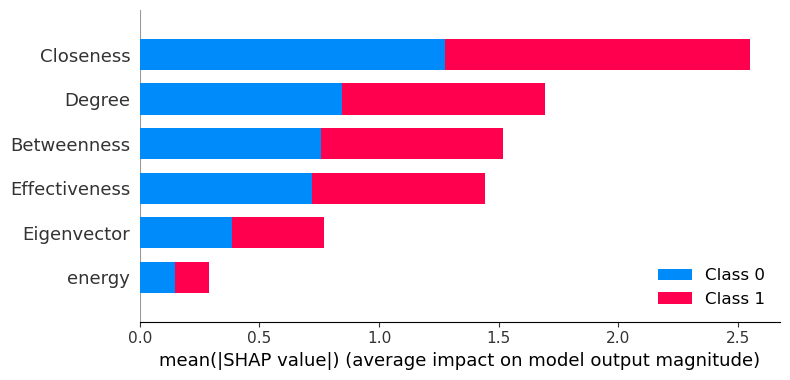

In [40]:
shap.summary_plot(shap_values, X)

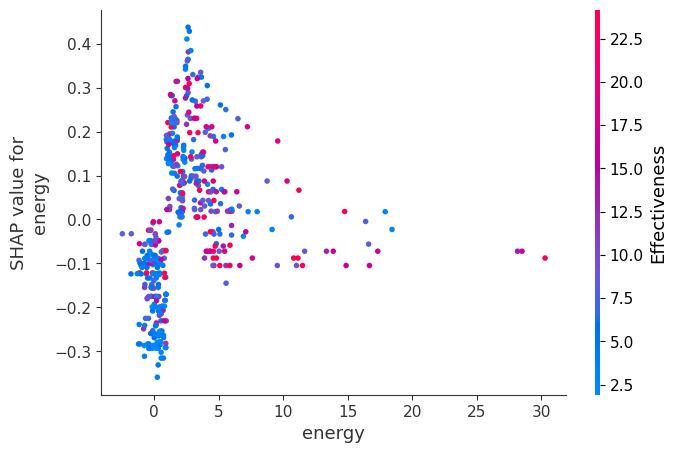

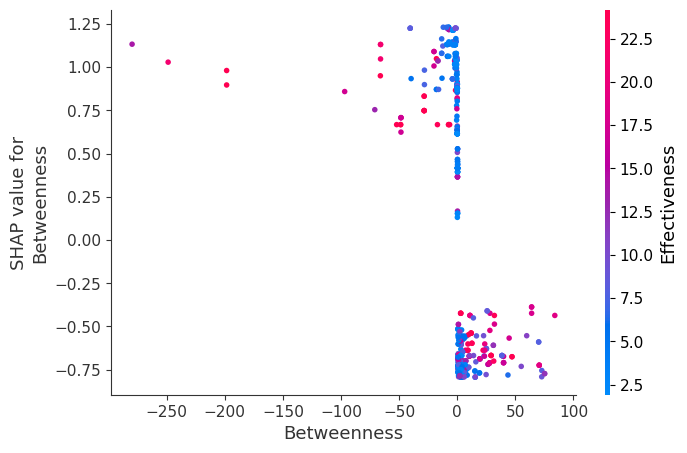

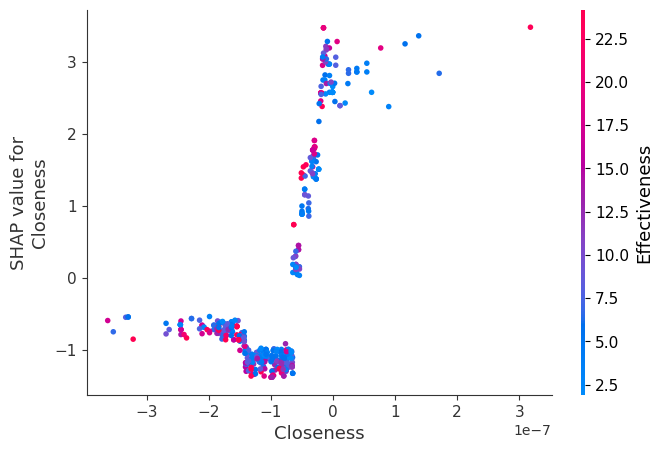

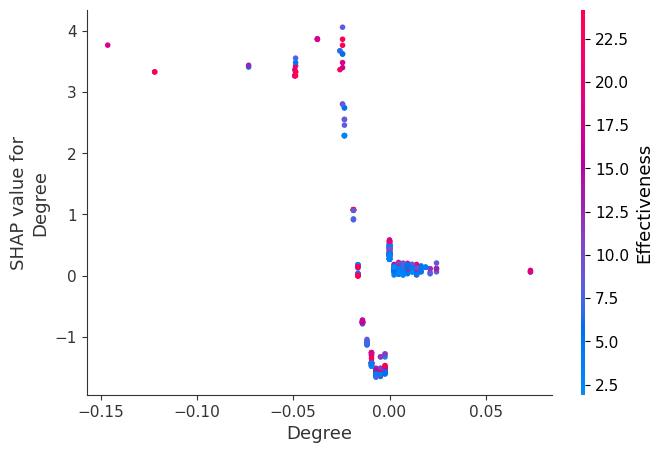

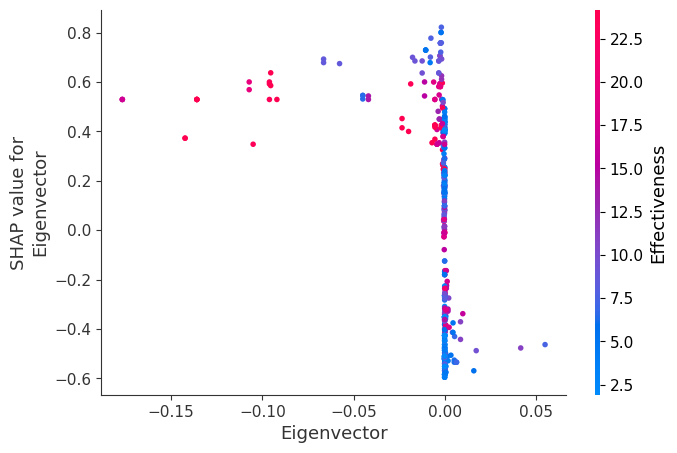

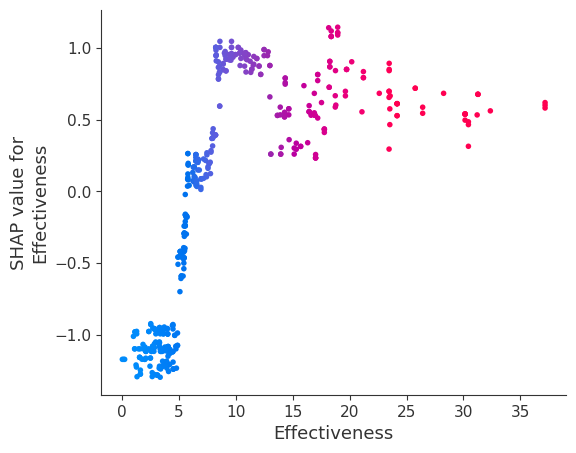

In [64]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X, display_features=X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


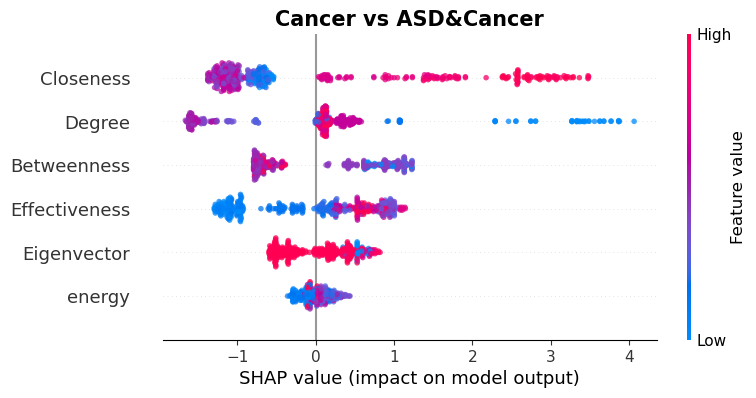

In [81]:
import matplotlib.pyplot as plt
fig = shap.summary_plot(shap_values[1], X, show = False,alpha=0.75)
plt.title("Cancer vs ASD&Cancer",fontweight='bold',fontsize = 15)
plt.savefig("shap_summary_plot_Cancer_AC.pdf", bbox_inches='tight')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


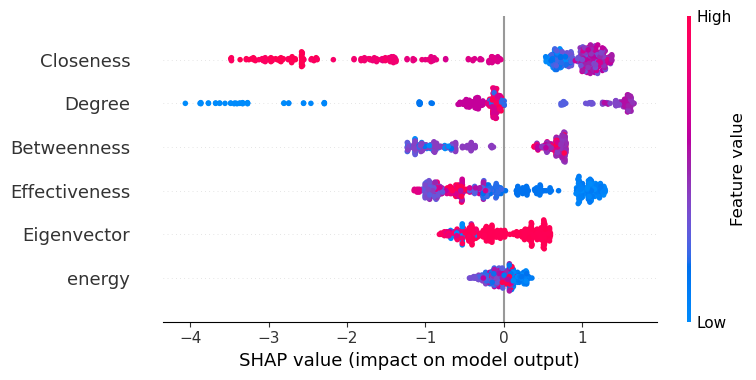

In [52]:
shap.summary_plot(shap_values[0], X)

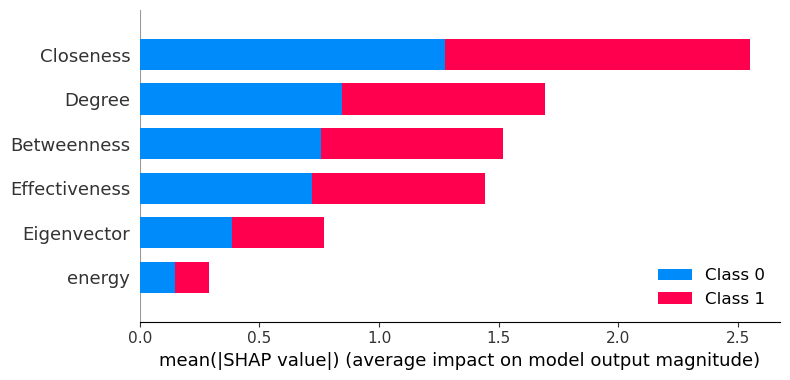

In [48]:
shap.summary_plot(shap_values, X_test, plot_type="bar")